## VISUALIZE GLODAP WHERE TA-DIC < 50, AT DEPTHS <1000

### LOOKING AT GLODAP

In [50]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [51]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Mythical code button"></form>''')

In [52]:
import arrow
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
plt.style.use('classic')
from matplotlib.patches import Rectangle
import pickle
from cmocean import cm
import warnings
import netCDF4 as nc
import sys
sys.path.append('../pyscripts/bylayer_extract/')
import extract_bylayer_mean_BOXMASK as ebmBOX 
from importlib import reload
from salishsea_tools import viz_tools

import sys
sys.path.append('/data/tjarniko/mocsy')
import mocsy

%matplotlib inline
warnings.simplefilter('ignore')

plt.rcParams.update({'font.size': 13,
                     'xtick.labelsize' : 13,
                     'ytick.labelsize' : 13})

In [53]:

def calculate_Egleston_factors(ttemp, tsal, talk, tdic_A, dep, del_dic):

    tdic_B = tdic_A + del_dic
    
    tzero = np.zeros_like(tdic_A)
    
    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_A, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tinsitu', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_A,pco2_A,fco2,co2_A,hco3,co3,OmegaA_A,OmegaC,BetaD,DENis,p,Tis = response_tup

    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_B, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tinsitu', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_B,pco2_B,fco2,co2_B,hco3,co3,OmegaA_B,OmegaC,BetaD,DENis,p,Tis = response_tup

    omega_DIC = 1/((np.log(OmegaA_B)-np.log(OmegaA_A))/(del_dic))
    
    Hplus_A = 10**(-1*pH_A); Hplus_B = 10**(-1*pH_B)
    beta_DIC = 1/((np.log(Hplus_B)-np.log(Hplus_A))/(del_dic))
    
    gamma_DIC = 1/((np.log(co2_B)-np.log(co2_A))/(del_dic))
    
    return omega_DIC, beta_DIC, gamma_DIC, OmegaA_A



In [54]:
import pandas as pd

df = pd.read_csv('./data_papers/GLODAPv2.2019_Merged_Master_File.csv')

dfcai = pd.read_csv('./32RC20160808_discrete_data.csv')


### cai data

note - not the 2013 cruise cited in the 2017 paper, but a 2016 cruise, same place, same people?
https://www.nodc.noaa.gov/ocads/data/0209358.xml

In [55]:


temp = np.array(dfcai['CTDTMP'][1:-1])
#print(temp)
dic = np.array(dfcai['TCARBN'][1:-1])
dic = dic.astype(np.float)
dic_f = np.array(dfcai['TCARBN_FLAG_W'][1:-1])
dic_f = dic_f.astype(np.float)

# #print(dic)
ta = np.array(dfcai['ALKALI'][1:-1])
ta = ta.astype(np.float)
ta_f = np.array(dfcai['ALKALI_FLAG_W'][1:-1])
ta_f = dic_f.astype(np.float)

sal = np.array(dfcai['SALNTY'][1:-1])
sal = sal.astype(np.float)
sal_f = np.array(dfcai['SALNTY_FLAG_W'][1:-1])
sal_f = sal.astype(np.float)

temp = np.array(dfcai['CTDTMP'][1:-1])
temp = temp.astype(np.float)
temp_f = np.array(dfcai['CTDTMP_FLAG_W'][1:-1])
temp_f = temp.astype(np.float)

depth = np.array(dfcai['DEPTH'][1:-1])
depth = depth.astype(np.float)

ta_dic = ta-dic

tflag = (dic_f==2)  & (ta_f == 2)

sal_u  = sal[tflag]
temp_u = temp[tflag]
dic_u = dic[tflag]
ta_u = ta[tflag]
depth_u = depth[tflag]
# plt.plot(sal_u,ta_u-dic_u,'r.')
# plt.xlabel('salinity')
# plt.ylabel('ta-dic')
# plt.axhline(y=50)

cai_omega_DIC, cai_beta_DIC, cai_gammaDIC, cai_OmegaA_A = \
calculate_Egleston_factors\
(temp_u, sal_u, ta_u *1e-3, dic_u *1e-3, depth_u, 0.01)


## 102 columns of the glodap dataset

In [56]:
# display  
data_top = list(df.columns) 


## take relevant parts of dataframe and make arrays

In [57]:
#need - bottom depth, pressure, dic, ta, salinity, temp, lat, lon
tALK = np.array(df['talk'][:])
tDIC = np.array(df['tco2'][:])
tDIC_p = tDIC + 50
tSAL = np.array(df['salinity'][:])
tTEMP = np.array(df['temperature'][:])
tPRES = np.array(df['pressure'][:])
tLAT = np.array(df['latitude'][:])
tLON = np.array(df['longitude'][:])
tBOTdepth = np.array(df['bottomdepth'][:])
tYEAR = np.array(df['year'])
tALK_DIC = tALK-tDIC
tALK_DIC_p = tALK-tDIC_p

print(type(tALK))

<class 'numpy.ndarray'>


##### filters - TA and DIC should exist, depth < 1000, TA-DIC conditions, etc

In [58]:
#dic, ta, actual reasonable numbers
filt_ALK = ((tALK>-9999) & (~np.isnan(tALK)))
filt_DIC = ((tDIC>-9999) & (~np.isnan(tDIC)))
filt_SAL = (tSAL >-9999) & (~np.isnan(tSAL))
filt_TEMP = (tTEMP >-9999) & (~np.isnan(tTEMP))
#bottom depth relatively shallow <
filt_DEPTH = (tBOTdepth < 1001) & filt_ALK & filt_DIC & filt_SAL
#year is modern
filt_DEPTH2 = (tBOTdepth < 501) & filt_ALK & filt_DIC & filt_SAL
filt_YEAR = (tYEAR > 1000)
filt_EST = (filt_SAL) & (tSAL >= 20 ) & (tPRES < 201)

filt_ALK_DIC = (np.abs(tALK_DIC) < 50) & (filt_ALK) & (filt_DIC) & (filt_SAL)
filt_ALK_DIC_p = (np.abs(tALK_DIC_p) < 50) & (filt_ALK) & (filt_DIC) & (filt_SAL)


#combined filters
all_dat = np.where(filt_ALK & filt_DIC & filt_SAL)
coast_dat = np.where(filt_ALK & filt_DIC & filt_SAL & filt_DEPTH)
coast_dat2 = np.where(filt_ALK & filt_DIC & filt_SAL & filt_DEPTH2)
coast_dat3 = np.where(filt_ALK & filt_DIC & ((np.isnan(tTEMP))\
                                             | (np.isnan(tSAL)) |  (tSAL <-99) | (tTEMP < - 99)))
print(np.shape(coast_dat3))
#print sum statz
print('total datapoints with dic, ta, sal: '+str(np.shape(all_dat[0])))
print('total datapoints with abs(TA-DIC)<50')
print(np.shape(np.where(filt_ALK_DIC)))
print('total datapoints with dic, ta, sal & depth <1000: '+str(np.shape(coast_dat[0])))
print('total datapoints with dic, ta, sal & depth <500: '+str(np.shape(coast_dat2[0])))
print('total datapoints of coastal (depth<1000) with abs(TA-DIC)<50')
print(np.shape(np.where(filt_ALK & filt_DIC & filt_SAL & filt_DEPTH&filt_ALK_DIC)))
print('total datapoints of coastal (depth<500) with abs(TA-DIC)<50')
print(np.shape(np.where(filt_ALK & filt_DIC & filt_SAL & filt_DEPTH2&filt_ALK_DIC)))

(1, 3168)
total datapoints with dic, ta, sal: (317586,)
total datapoints with abs(TA-DIC)<50
(1, 28121)
total datapoints with dic, ta, sal & depth <1000: (23376,)
total datapoints with dic, ta, sal & depth <500: (15894,)
total datapoints of coastal (depth<1000) with abs(TA-DIC)<50
(1, 1228)
total datapoints of coastal (depth<500) with abs(TA-DIC)<50
(1, 817)


## map of coastal (d<500) data, highlighting where abs(ta-dic) < 50

In [59]:
# from mpl_toolkits.basemap import Basemap
# import numpy as np
# import matplotlib.pyplot as plt
# # create new figure, axes instances.
# fig=plt.figure()
# ax=fig.add_axes([0.1,0.1,3.8,3.8])
# # setup mercator map projection.
# m = Basemap(llcrnrlon=-180.,llcrnrlat=-80.,urcrnrlon=180.,urcrnrlat=85.,\
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',projection='merc',\
#             lat_0=40.,lon_0=-20.,lat_ts=20.)


# #lonlat = t_latval; lonlon = t_lonval

# m.drawcoastlines()
# m.fillcontinents(color = 'goldenrod')
# # draw parallels
# m.drawparallels(np.arange(-90,90,20),labels=[1,1,0,1])
# # draw meridians
# m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

# #lonlat = t_latval; lonlon = t_lonval
# x,y = m(tLON[filt_DEPTH2 & filt_EST], tLAT[filt_DEPTH2& filt_EST])
# m.plot(x, y, 'bo', markersize=5, label = 'TA & DIC exist, d < 500')


# plt.legend()
# plt.show()

In [60]:
# from mpl_toolkits.basemap import Basemap
# import numpy as np
# import matplotlib.pyplot as plt
# # create new figure, axes instances.
# fig=plt.figure()
# ax=fig.add_axes([0.1,0.1,3.8,3.8])
# # setup mercator map projection.
# m = Basemap(llcrnrlon=-180.,llcrnrlat=-80.,urcrnrlon=180.,urcrnrlat=85.,\
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',projection='merc',\
#             lat_0=40.,lon_0=-20.,lat_ts=20.)


# #lonlat = t_latval; lonlon = t_lonval

# m.drawcoastlines()
# m.fillcontinents(color = 'goldenrod')
# # draw parallels
# m.drawparallels(np.arange(-90,90,20),labels=[1,1,0,1])
# # draw meridians
# m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

# #lonlat = t_latval; lonlon = t_lonval
# x,y = m(tLON[filt_DEPTH2& filt_EST], tLAT[filt_DEPTH2& filt_EST])
# m.plot(x, y, 'bo', markersize=5, label = 'TA & DIC exist, d < 500')

# x,y = m(tLON[filt_DEPTH2& filt_EST&(filt_ALK_DIC)], tLAT[filt_DEPTH2& filt_EST&(filt_ALK_DIC)])
# m.plot(x, y, 'ro', markersize=9, label = 'TA & DIC exist, d< 500 & TA-DIC <50')

# plt.legend()
# plt.show()

In [61]:
# from mpl_toolkits.basemap import Basemap
# import numpy as np
# import matplotlib.pyplot as plt
# # create new figure, axes instances.
# fig=plt.figure()
# ax=fig.add_axes([0.1,0.1,3.8,3.8])
# # setup mercator map projection.
# m = Basemap(llcrnrlon=-180.,llcrnrlat=-80.,urcrnrlon=180.,urcrnrlat=85.,\
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',projection='merc',\
#             lat_0=40.,lon_0=-20.,lat_ts=20.)


# #lonlat = t_latval; lonlon = t_lonval

# m.drawcoastlines()
# m.fillcontinents(color = 'goldenrod')
# # draw parallels
# m.drawparallels(np.arange(-90,90,20),labels=[1,1,0,1])
# # draw meridians
# m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

# #lonlat = t_latval; lonlon = t_lonval
# x,y = m(tLON[filt_DEPTH2& filt_EST], tLAT[filt_DEPTH2& filt_EST])
# m.plot(x, y, 'bo', markersize=5, label = 'TA & DIC exist, d < 500')

# x,y = m(tLON[filt_DEPTH2& filt_EST&(filt_ALK_DIC_p)], tLAT[filt_DEPTH2& filt_EST&(filt_ALK_DIC_p)])
# m.plot(x, y, 'go', markersize=9, label = 'TA & DIC exist, d< 500 & TA-DIC_p <50')


# x,y = m(tLON[filt_DEPTH2& filt_EST&(filt_ALK_DIC)], tLAT[filt_DEPTH2& filt_EST&(filt_ALK_DIC)])
# m.plot(x, y, 'ro', markersize=9, label = 'TA & DIC exist, d< 500 & TA-DIC <50')


# plt.legend()
# plt.show()

## let's define geographic regions

In [62]:
tGEO = np.zeros_like(tBOTdepth)

#canadian arctic
westlon = -148; eastlon = -50; southlat = 60; northlat = 85
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 1
print(np.shape(tGEO[tGEO==1]))
#euro arctic
westlon = -30; eastlon = 91; southlat = 70; northlat = 85
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 2
#atlantic 1
westlon = -50; eastlon = 30; southlat = 0; northlat = 70
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 3
#atlantic 2
westlon = -100; eastlon = -50; southlat = 0; northlat = 60
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 3
#siberian arctic
westlon = 91; eastlon = 180; southlat = 68; northlat = 91
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 4
#pacific coast
westlon = -140; eastlon = -100; southlat = 10; northlat = 60
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 5
#Russian-Alaskan Interface
westlon = -180; eastlon = -148; southlat = 50; northlat = 90
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 6
#Kamchatka Region
westlon = 120; eastlon = 180; southlat = 48; northlat = 68
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 7
#Japan and China
westlon = 120; eastlon = 180; southlat = 10; northlat = 48
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 8
#SO
westlon = -180; eastlon = 180; southlat = -90; northlat = -60
tGEO[(tLON>westlon)& (tLON<eastlon) & (tLAT>southlat) & (tLAT<northlat)] = 9

(26639,)


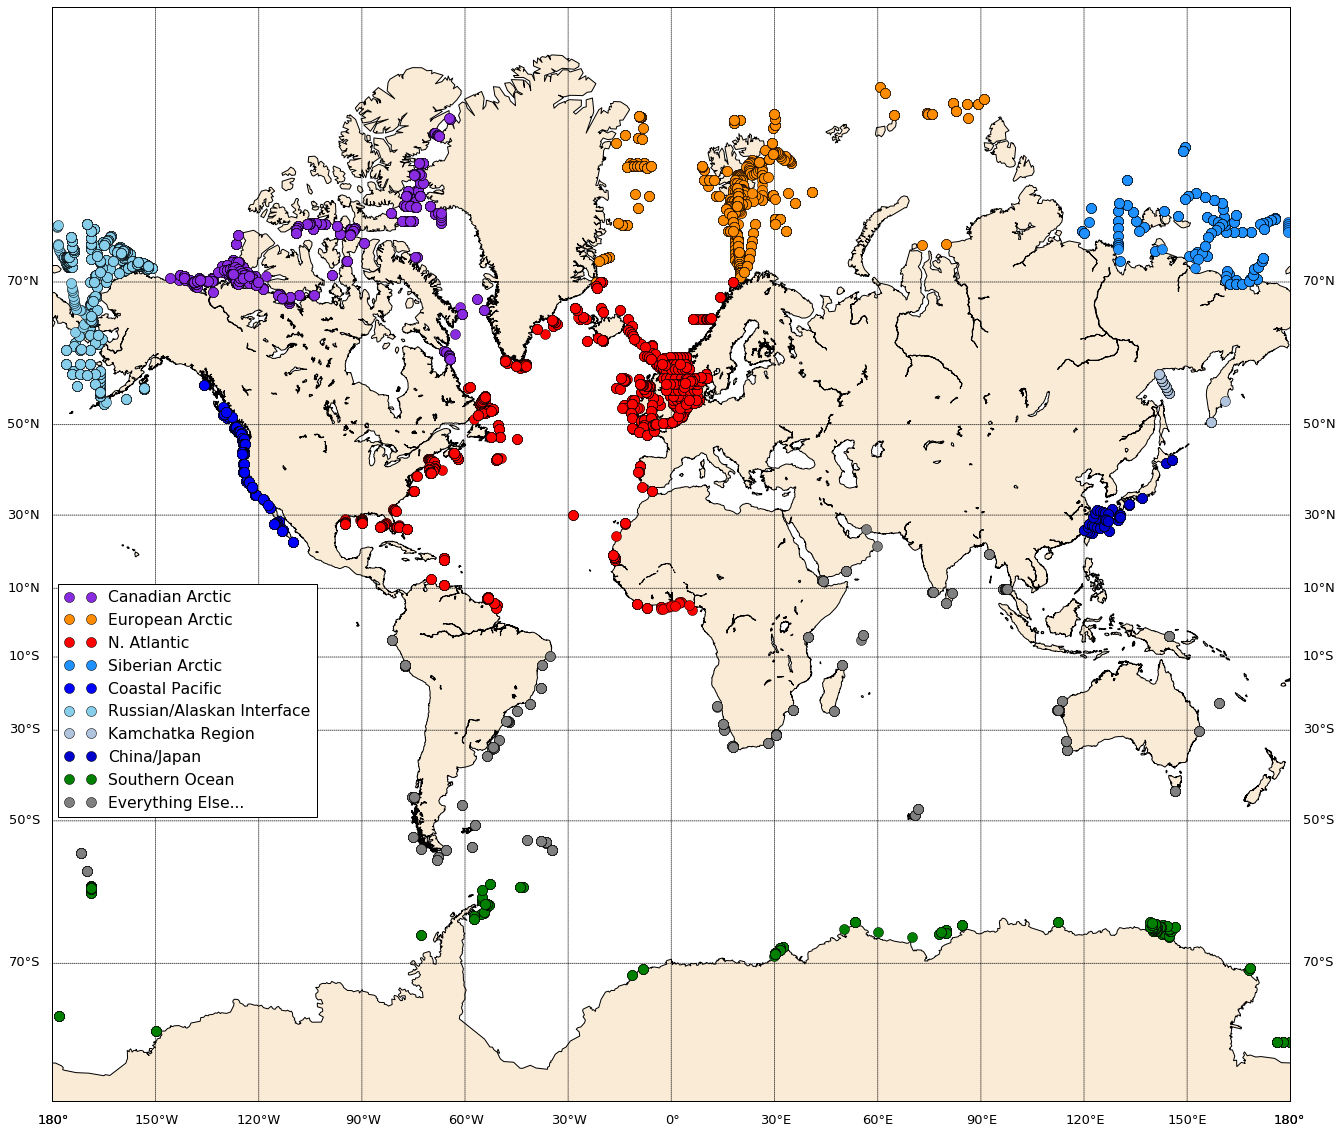

In [63]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# create new figure, axes instances.
fig=plt.figure()
ax=fig.add_axes([0.1,0.1,3.8,3.8])
# setup mercator map projection.
m = Basemap(llcrnrlon=-180.,llcrnrlat=-80.,urcrnrlon=180.,urcrnrlat=85.,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)


m.drawcoastlines()
m.fillcontinents(color = 'antiquewhite')
# draw parallels
m.drawparallels(np.arange(-90,90,20),labels=[1,1,0,1])
# draw meridians
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

this_lon = tLON[(tGEO == 1)&filt_DEPTH2& filt_EST]
this_lat = tLAT[(tGEO == 1)&filt_DEPTH2& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'blueviolet', markersize=10,\
       marker = 'o', markeredgecolor = None, linestyle = '',\
       label = 'Canadian Arctic')

this_lon = tLON[(tGEO == 2)&filt_DEPTH2& filt_EST]
this_lat = tLAT[(tGEO == 2)&filt_DEPTH2& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'darkorange', markersize=10,\
       marker = 'o', markeredgecolor = None, linestyle = '',\
       label = 'European Arctic')

this_lon = tLON[(tGEO == 3)&filt_DEPTH2& filt_EST]
this_lat = tLAT[(tGEO == 3)&filt_DEPTH2& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'red', markersize=10,\
       marker = 'o', markeredgecolor = None, linestyle = '',\
       label = 'N. Atlantic')

this_lon = tLON[(tGEO == 4)&filt_DEPTH2& filt_EST]
this_lat = tLAT[(tGEO == 4)&filt_DEPTH2& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'dodgerblue', markersize=10,\
       marker = 'o', markeredgecolor = None, linestyle = '',\
       label = 'Siberian Arctic')

this_lon = tLON[(tGEO == 5)&filt_DEPTH2& filt_EST]
this_lat = tLAT[(tGEO == 5)&filt_DEPTH2& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'blue', markersize=10,\
       marker = 'o', markeredgecolor = None, linestyle = '',\
       label = 'Coastal Pacific')

this_lon = tLON[(tGEO == 6)&filt_DEPTH2& filt_EST]
this_lat = tLAT[(tGEO == 6)&filt_DEPTH2& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'skyblue', markersize=10,\
       marker = 'o', markeredgecolor = None, linestyle = '',\
       label = 'Russian/Alaskan Interface')

this_lon = tLON[(tGEO == 7)&filt_DEPTH2& filt_EST]
this_lat = tLAT[(tGEO == 7)&filt_DEPTH2& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'lightsteelblue', markersize=10,\
       marker = 'o', markeredgecolor = None, linestyle = '',\
       label = 'Kamchatka Region')

this_lon = tLON[(tGEO == 8)&filt_DEPTH2& filt_EST]
this_lat = tLAT[(tGEO == 8)&filt_DEPTH2& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'mediumblue', markersize=10,\
       marker = 'o', markeredgecolor = None, linestyle = '',\
       label = 'China/Japan')


this_lon = tLON[(tGEO == 9)&filt_DEPTH2& filt_EST]
this_lat = tLAT[(tGEO == 9)&filt_DEPTH2& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'green', markersize=10,\
       marker = 'o', markeredgecolor = None, linestyle = '',\
       label = 'Southern Ocean')

this_lon = tLON[(tGEO == 0)&filt_DEPTH2& filt_EST]
this_lat = tLAT[(tGEO == 0)&filt_DEPTH2& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'grey', markersize=10,\
       marker = 'o', markeredgecolor = None, linestyle = '',\
       label = 'Everything Else...')


plt.legend(bbox_to_anchor=[0.22, 0.48])
plt.show()

In [64]:
PLACES_withdat = {
'Canadian Arctic': { 'geodat': 1, 'colour': 'blueviolet', 'name':'Canadian Arctic'},
'European Arctic': { 'geodat': 2, 'colour': 'darkorange', 'name':'European Arctic'},
'N. Atlantic': { 'geodat': 3, 'colour': 'red', 'name':'N. Atlantic'},
'Siberian Arctic': { 'geodat': 4, 'colour': 'dodgerblue', 'name':'Siberian Arctic'},
'Coastal Pacific': { 'geodat': 5, 'colour': 'blue', 'name':'Coastal Pacific'},
'Russian/Alaskan Interface': { 'geodat': 6, 'colour': 'skyblue', 'name':'Russian/Alaskan Interface'},
'Kamchatka Region': { 'geodat': 7, 'colour': 'lightsteelblue', 'name':'Kamchatka Region'},
'China/Japan': { 'geodat': 8, 'colour': 'midnightblue', 'name':'China/Japan'},
'Southern Ocean': { 'geodat': 9, 'colour': 'green', 'name':'Southern Ocean'},
'Everything Else': { 'geodat': 0, 'colour': 'grey', 'name':'Everything Else'},
}

list_places = ['Canadian Arctic','European Arctic',
'N. Atlantic','Siberian Arctic','Coastal Pacific',
'Russian/Alaskan Interface',
'Kamchatka Region','China/Japan',
'Southern Ocean',
'Everything Else',
]

print(list_places)

['Canadian Arctic', 'European Arctic', 'N. Atlantic', 'Siberian Arctic', 'Coastal Pacific', 'Russian/Alaskan Interface', 'Kamchatka Region', 'China/Japan', 'Southern Ocean', 'Everything Else']


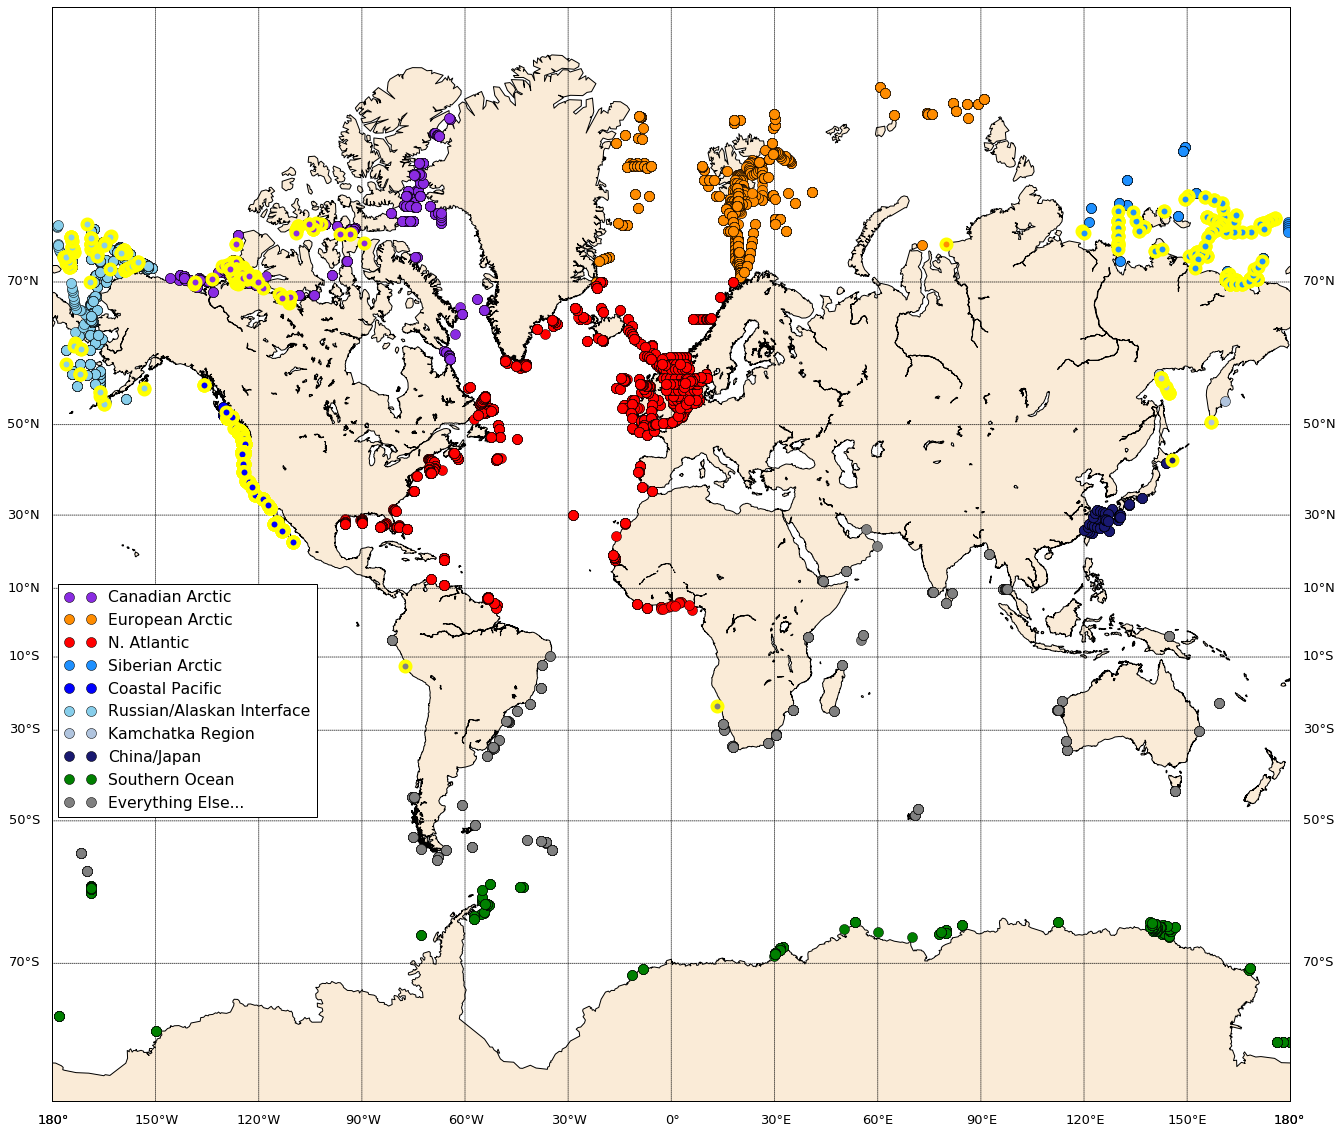

In [65]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# create new figure, axes instances.
fig=plt.figure()
ax=fig.add_axes([0.1,0.1,3.8,3.8])
# setup mercator map projection.
m = Basemap(llcrnrlon=-180.,llcrnrlat=-80.,urcrnrlon=180.,urcrnrlat=85.,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)


m.drawcoastlines()
m.fillcontinents(color = 'antiquewhite')
# draw parallels
m.drawparallels(np.arange(-90,90,20),labels=[1,1,0,1])
# draw meridians
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

this_lon = tLON[(tGEO == 1)&filt_DEPTH2& filt_EST]
this_lat = tLAT[(tGEO == 1)&filt_DEPTH2& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'blueviolet', markersize=10,\
       marker = 'o', markeredgecolor = None, linestyle = '',\
       label = 'Canadian Arctic')
this_lon = tLON[(tGEO == 1)&filt_DEPTH2&filt_ALK_DIC& filt_EST]
this_lat = tLAT[(tGEO == 1)&filt_DEPTH2&filt_ALK_DIC& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'blueviolet', markersize=10,\
       marker = 'o', markeredgecolor = 'yellow', markeredgewidth = 4, linestyle = '')

this_lon = tLON[(tGEO == 2)&filt_DEPTH2]
this_lat = tLAT[(tGEO == 2)&filt_DEPTH2]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'darkorange', markersize=10,\
       marker = 'o', markeredgecolor = None, linestyle = '',\
       label = 'European Arctic')
this_lon = tLON[(tGEO == 2)&filt_DEPTH2&filt_ALK_DIC& filt_EST]
this_lat = tLAT[(tGEO == 2)&filt_DEPTH2&filt_ALK_DIC& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'darkorange', markersize=10,\
       marker = 'o', markeredgecolor = 'yellow', markeredgewidth = 4, linestyle = '')

this_lon = tLON[(tGEO == 3)&filt_DEPTH2]
this_lat = tLAT[(tGEO == 3)&filt_DEPTH2]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'red', markersize=10,\
       marker = 'o', markeredgecolor = None, linestyle = '',\
       label = 'N. Atlantic')
this_lon = tLON[(tGEO == 3)&filt_DEPTH2&filt_ALK_DIC& filt_EST]
this_lat = tLAT[(tGEO == 3)&filt_DEPTH2&filt_ALK_DIC& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'red', markersize=10,\
       marker = 'o', markeredgecolor = 'yellow', markeredgewidth = 4, linestyle = '')

this_lon = tLON[(tGEO == 4)&filt_DEPTH2& filt_EST]
this_lat = tLAT[(tGEO == 4)&filt_DEPTH2& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'dodgerblue', markersize=10,\
       marker = 'o', markeredgecolor = None, linestyle = '',\
       label = 'Siberian Arctic')
this_lon = tLON[(tGEO == 4)&filt_DEPTH2&filt_ALK_DIC& filt_EST]
this_lat = tLAT[(tGEO == 4)&filt_DEPTH2&filt_ALK_DIC& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'dodgerblue', markersize=10,\
       marker = 'o', markeredgecolor = 'yellow', markeredgewidth = 4, linestyle = '')

this_lon = tLON[(tGEO == 5)&filt_DEPTH2]
this_lat = tLAT[(tGEO == 5)&filt_DEPTH2]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'blue', markersize=10,\
       marker = 'o', markeredgecolor = None, linestyle = '',\
       label = 'Coastal Pacific')
this_lon = tLON[(tGEO == 5)&filt_DEPTH2&filt_ALK_DIC]
this_lat = tLAT[(tGEO == 5)&filt_DEPTH2&filt_ALK_DIC]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'blue', markersize=10,\
       marker = 'o', markeredgecolor = 'yellow', markeredgewidth = 4, linestyle = '')

this_lon = tLON[(tGEO == 6)&filt_DEPTH2& filt_EST]
this_lat = tLAT[(tGEO == 6)&filt_DEPTH2& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'skyblue', markersize=10,\
       marker = 'o', markeredgecolor = None, linestyle = '',\
       label = 'Russian/Alaskan Interface')
this_lon = tLON[(tGEO == 6)&filt_DEPTH2&filt_ALK_DIC& filt_EST]
this_lat = tLAT[(tGEO == 6)&filt_DEPTH2&filt_ALK_DIC& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'skyblue', markersize=10,\
       marker = 'o', markeredgecolor = 'yellow', markeredgewidth = 4, linestyle = '')

this_lon = tLON[(tGEO == 7)&filt_DEPTH2& filt_EST]
this_lat = tLAT[(tGEO == 7)&filt_DEPTH2& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'lightsteelblue', markersize=10,\
       marker = 'o', markeredgecolor = None, linestyle = '',\
       label = 'Kamchatka Region')
this_lon = tLON[(tGEO == 7)&filt_DEPTH2&filt_ALK_DIC& filt_EST]
this_lat = tLAT[(tGEO == 7)&filt_DEPTH2&filt_ALK_DIC& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'lightsteelblue', markersize=10,\
       marker = 'o', markeredgecolor = 'yellow', markeredgewidth = 4, linestyle = '')

this_lon = tLON[(tGEO == 8)&filt_DEPTH2& filt_EST]
this_lat = tLAT[(tGEO == 8)&filt_DEPTH2& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'midnightblue', markersize=10,\
       marker = 'o', markeredgecolor = None, linestyle = '',\
       label = 'China/Japan')
this_lon = tLON[(tGEO == 8)&filt_DEPTH2&filt_ALK_DIC& filt_EST]
this_lat = tLAT[(tGEO == 8)&filt_DEPTH2&filt_ALK_DIC& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'midnightblue', markersize=10,\
       marker = 'o', markeredgecolor = 'yellow', markeredgewidth = 4, linestyle = '')

this_lon = tLON[(tGEO == 9)&filt_DEPTH2& filt_EST]
this_lat = tLAT[(tGEO == 9)&filt_DEPTH2& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'green', markersize=10,\
       marker = 'o', markeredgecolor = None, linestyle = '',\
       label = 'Southern Ocean')
this_lon = tLON[(tGEO == 9)&filt_DEPTH2&filt_ALK_DIC& filt_EST]
this_lat = tLAT[(tGEO == 9)&filt_DEPTH2&filt_ALK_DIC& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'green', markersize=10,\
       marker = 'o', markeredgecolor = 'yellow', markeredgewidth = 4, linestyle = '')

this_lon = tLON[(tGEO == 0)&filt_DEPTH2& filt_EST]
this_lat = tLAT[(tGEO == 0)&filt_DEPTH2& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'grey', markersize=10,\
       marker = 'o', markeredgecolor = None, linestyle = '',\
       label = 'Everything Else...')
this_lon = tLON[(tGEO == 0)&filt_DEPTH2&filt_ALK_DIC& filt_EST]
this_lat = tLAT[(tGEO == 0)&filt_DEPTH2&filt_ALK_DIC& filt_EST]
x,y = m(this_lon, this_lat)
m.plot(x, y, markerfacecolor = 'grey', markersize=10,\
       marker = 'o', markeredgecolor = 'yellow', markeredgewidth = 4, linestyle = '')

plt.legend(bbox_to_anchor=[0.22, 0.48])
plt.show()

In [66]:

def calculate_Egleston_factors(ttemp, tsal, talk, tdic_A, dep, del_dic):

    tdic_B = tdic_A + del_dic
    
    tzero = np.zeros_like(tdic_A)
    
    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_A, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tinsitu', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_A,pco2_A,fco2,co2_A,hco3,co3,OmegaA_A,OmegaC,BetaD,DENis,p,Tis = response_tup

    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_B, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tinsitu', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_B,pco2_B,fco2,co2_B,hco3,co3,OmegaA_B,OmegaC,BetaD,DENis,p,Tis = response_tup

    omega_DIC = 1/((np.log(OmegaA_B)-np.log(OmegaA_A))/(del_dic))
    
    Hplus_A = 10**(-1*pH_A); Hplus_B = 10**(-1*pH_B)
    beta_DIC = 1/((np.log(Hplus_B)-np.log(Hplus_A))/(del_dic))
    
    gamma_DIC = 1/((np.log(co2_B)-np.log(co2_A))/(del_dic))
    
    return omega_DIC, beta_DIC, gamma_DIC, OmegaA_A



## calc omega and factors for glodap data

In [67]:
t_omega_DIC, t_beta_DIC, t_gammaDIC, t_OmegaA_A = \
calculate_Egleston_factors\
(tTEMP, tSAL, tALK*1e-3, tDIC*1e-3, tPRES, 0.01)

t_omega_DIC_p, t_beta_DIC_p, t_gammaDIC_, t_OmegaA_A_p = \
calculate_Egleston_factors\
(tTEMP, tSAL, tALK*1e-3, tDIC_p*1e-3, tPRES, 0.01)


## calc omega and factors for SKOG data

In [68]:
BR3_DIC_jdf = pickle.load(open('../pkls/BR3_DIC_means_jdf_BOX.pkl','rb'))
BR3_TA_jdf = pickle.load(open('../pkls/BR3_TA_means_jdf_BOX.pkl','rb'))
BR3_sal_jdf = pickle.load(open('../pkls/BR3_sal_means_jdf_BOX.pkl','rb'))
BR3_temp_jdf = pickle.load(open('../pkls/BR3_temp_means_jdf_BOX.pkl','rb'))

PI4_DIC_jdf = pickle.load(open('../pkls/PI4_DIC_means_jdf_BOX.pkl','rb'))
PI4_TA_jdf = pickle.load(open('../pkls/PI4_TA_means_jdf_BOX.pkl','rb'))
PI4_sal_jdf = pickle.load(open('../pkls/PI4_sal_means_jdf_BOX.pkl','rb'))
PI4_temp_jdf = pickle.load(open('../pkls/PI4_temp_means_jdf_BOX.pkl','rb'))

BR3_DIC_cs2 = pickle.load(open('../pkls/BR3_DIC_means_cs2_BOX.pkl','rb'))
BR3_TA_cs2 = pickle.load(open('../pkls/BR3_TA_means_cs2_BOX.pkl','rb'))
BR3_sal_cs2 = pickle.load(open('../pkls/BR3_sal_means_cs2_BOX.pkl','rb'))
BR3_temp_cs2 = pickle.load(open('../pkls/BR3_temp_means_cs2_BOX.pkl','rb'))

PI4_DIC_cs2 = pickle.load(open('../pkls/PI4_DIC_means_cs2_BOX.pkl','rb'))
PI4_TA_cs2 = pickle.load(open('../pkls/PI4_TA_means_cs2_BOX.pkl','rb'))
PI4_sal_cs2 = pickle.load(open('../pkls/PI4_sal_means_cs2_BOX.pkl','rb'))
PI4_temp_cs2 = pickle.load(open('../pkls/PI4_temp_means_cs2_BOX.pkl','rb'))

BR3_DIC_cs2_summer =np.nanmean(BR3_DIC_cs2[:,152:244], axis = 1)
BR3_TA_cs2_summer = np.nanmean(BR3_TA_cs2[:,152:244], axis = 1)
BR3_sal_cs2_summer = np.nanmean(BR3_sal_cs2[:,152:244], axis = 1)
BR3_temp_cs2_summer = np.nanmean(BR3_temp_cs2[:,152:244], axis = 1)

BR3_DIC_cs2_winter = \
np.nanmean(np.concatenate((BR3_DIC_cs2[:,0:59],BR3_DIC_cs2[:,335:365]), axis =1 ),axis = 1)
BR3_TA_cs2_winter = \
np.nanmean(np.concatenate((BR3_TA_cs2[:,0:59],BR3_TA_cs2[:,335:365]), axis =1 ),axis = 1)
BR3_sal_cs2_winter = \
np.nanmean(np.concatenate((BR3_sal_cs2[:,0:59],BR3_sal_cs2[:,335:365]), axis =1 ),axis = 1)
BR3_temp_cs2_winter = \
np.nanmean(np.concatenate((BR3_temp_cs2[:,0:59],BR3_temp_cs2[:,335:365]), axis =1 ),axis = 1)

BR3_DIC_jdf_summer =np.nanmean(BR3_DIC_jdf[:,152:244], axis = 1)
BR3_TA_jdf_summer = np.nanmean(BR3_TA_jdf[:,152:244], axis = 1)
BR3_sal_jdf_summer = np.nanmean(BR3_sal_jdf[:,152:244], axis = 1)
BR3_temp_jdf_summer = np.nanmean(BR3_temp_jdf[:,152:244], axis = 1)

BR3_DIC_jdf_winter = \
np.nanmean(np.concatenate((BR3_DIC_jdf[:,0:59],BR3_DIC_jdf[:,335:365]), axis =1 ),axis = 1)
BR3_TA_jdf_winter = \
np.nanmean(np.concatenate((BR3_TA_jdf[:,0:59],BR3_TA_jdf[:,335:365]), axis =1 ),axis = 1)
BR3_sal_jdf_winter = \
np.nanmean(np.concatenate((BR3_sal_jdf[:,0:59],BR3_sal_jdf[:,335:365]), axis =1 ),axis = 1)
BR3_temp_jdf_winter = \
np.nanmean(np.concatenate((BR3_temp_jdf[:,0:59],BR3_temp_jdf[:,335:365]), axis =1 ),axis = 1)


PI4_DIC_cs2_summer =np.nanmean(PI4_DIC_cs2[:,152:244], axis = 1)
PI4_TA_cs2_summer = np.nanmean(PI4_TA_cs2[:,152:244], axis = 1)
PI4_sal_cs2_summer = np.nanmean(PI4_sal_cs2[:,152:244], axis = 1)
PI4_temp_cs2_summer = np.nanmean(PI4_temp_cs2[:,152:244], axis = 1)

PI4_DIC_cs2_winter = \
np.nanmean(np.concatenate((PI4_DIC_cs2[:,0:59],PI4_DIC_cs2[:,335:365]), axis =1 ),axis = 1)
PI4_TA_cs2_winter = \
np.nanmean(np.concatenate((PI4_TA_cs2[:,0:59],PI4_TA_cs2[:,335:365]), axis =1 ),axis = 1)
PI4_sal_cs2_winter = \
np.nanmean(np.concatenate((PI4_sal_cs2[:,0:59],PI4_sal_cs2[:,335:365]), axis =1 ),axis = 1)
PI4_temp_cs2_winter = \
np.nanmean(np.concatenate((PI4_temp_cs2[:,0:59],PI4_temp_cs2[:,335:365]), axis =1 ),axis = 1)

PI4_DIC_jdf_summer =np.nanmean(PI4_DIC_jdf[:,152:244], axis = 1)
PI4_TA_jdf_summer = np.nanmean(PI4_TA_jdf[:,152:244], axis = 1)
PI4_sal_jdf_summer = np.nanmean(PI4_sal_jdf[:,152:244], axis = 1)
PI4_temp_jdf_summer = np.nanmean(PI4_temp_jdf[:,152:244], axis = 1)

PI4_DIC_jdf_winter = \
np.nanmean(np.concatenate((PI4_DIC_jdf[:,0:59],PI4_DIC_jdf[:,335:365]), axis =1 ),axis = 1)
PI4_TA_jdf_winter = \
np.nanmean(np.concatenate((PI4_TA_jdf[:,0:59],PI4_TA_jdf[:,335:365]), axis =1 ),axis = 1)
PI4_sal_jdf_winter = \
np.nanmean(np.concatenate((PI4_sal_jdf[:,0:59],PI4_sal_jdf[:,335:365]), axis =1 ),axis = 1)
PI4_temp_jdf_winter = \
np.nanmean(np.concatenate((PI4_temp_jdf[:,0:59],PI4_temp_jdf[:,335:365]), axis =1 ),axis = 1)


depths = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

depth = depths['gdept_1d'][0,:]

PI4_TA_DIC_jdf_winter = PI4_TA_jdf_winter-PI4_DIC_jdf_winter
PI4_TA_DIC_jdf_summer = PI4_TA_jdf_summer-PI4_DIC_jdf_summer
BR3_TA_DIC_jdf_winter = BR3_TA_jdf_winter-BR3_DIC_jdf_winter
BR3_TA_DIC_jdf_summer = BR3_TA_jdf_summer-BR3_DIC_jdf_summer
PI4_TA_DIC_cs2_winter = PI4_TA_cs2_winter-PI4_DIC_cs2_winter
PI4_TA_DIC_cs2_summer = PI4_TA_cs2_summer-PI4_DIC_cs2_summer
BR3_TA_DIC_cs2_winter = BR3_TA_cs2_winter-BR3_DIC_cs2_winter
BR3_TA_DIC_cs2_summer = BR3_TA_cs2_summer-BR3_DIC_cs2_summer

PI4_omega_DIC_jdf_winter, PI4_beta_DIC_jdf_winter, PI4_gamma_DIC_jdf_winter, PI4_OmegaA_A_jdf_winter = \
calculate_Egleston_factors\
(PI4_temp_jdf_winter, PI4_sal_jdf_winter, PI4_TA_jdf_winter*1e-3, PI4_DIC_jdf_winter*1e-3, depth, 0.01)

PI4_omega_DIC_jdf_summer, PI4_beta_DIC_jdf_summer, PI4_gamma_DIC_jdf_summer, PI4_OmegaA_A_jdf_summer = \
calculate_Egleston_factors\
(PI4_temp_jdf_summer, PI4_sal_jdf_summer, PI4_TA_jdf_summer*1e-3, PI4_DIC_jdf_summer*1e-3, depth, 0.01)

BR3_omega_DIC_jdf_winter, BR3_beta_DIC_jdf_winter, BR3_gamma_DIC_jdf_winter, BR3_OmegaA_A_jdf_winter= \
calculate_Egleston_factors\
(BR3_temp_jdf_winter, BR3_sal_jdf_winter, BR3_TA_jdf_winter*1e-3, BR3_DIC_jdf_winter*1e-3, depth, 0.01)

BR3_omega_DIC_jdf_summer, BR3_beta_DIC_jdf_summer, BR3_gamma_DIC_jdf_summer, BR3_OmegaA_A_jdf_summer= \
calculate_Egleston_factors\
(BR3_temp_jdf_summer, BR3_sal_jdf_summer, BR3_TA_jdf_summer*1e-3, BR3_DIC_jdf_summer*1e-3, depth, 0.01)

PI4_omega_DIC_cs2_winter, PI4_beta_DIC_cs2_winter, PI4_gamma_DIC_cs2_winter, PI4_OmegaA_A_cs2_winter = \
calculate_Egleston_factors\
(PI4_temp_cs2_winter, PI4_sal_cs2_winter, PI4_TA_cs2_winter*1e-3, PI4_DIC_cs2_winter*1e-3, depth, 0.01)

PI4_omega_DIC_cs2_summer, PI4_beta_DIC_cs2_summer, PI4_gamma_DIC_cs2_summer, PI4_OmegaA_A_cs2_summer = \
calculate_Egleston_factors\
(PI4_temp_cs2_summer, PI4_sal_cs2_summer, PI4_TA_cs2_summer*1e-3, PI4_DIC_cs2_summer*1e-3, depth, 0.01)

BR3_omega_DIC_cs2_winter, BR3_beta_DIC_cs2_winter, BR3_gamma_DIC_cs2_winter, BR3_OmegaA_A_cs2_winter = \
calculate_Egleston_factors\
(BR3_temp_cs2_winter, BR3_sal_cs2_winter, BR3_TA_cs2_winter*1e-3, BR3_DIC_cs2_winter*1e-3, depth, 0.01)

BR3_omega_DIC_cs2_summer, BR3_beta_DIC_cs2_summer, BR3_gamma_DIC_cs2_summer, BR3_OmegaA_A_cs2_summer = \
calculate_Egleston_factors\
(BR3_temp_cs2_summer, BR3_sal_cs2_summer, BR3_TA_cs2_summer*1e-3, BR3_DIC_cs2_summer*1e-3, depth, 0.01)


## TA-DIC vs Salinity

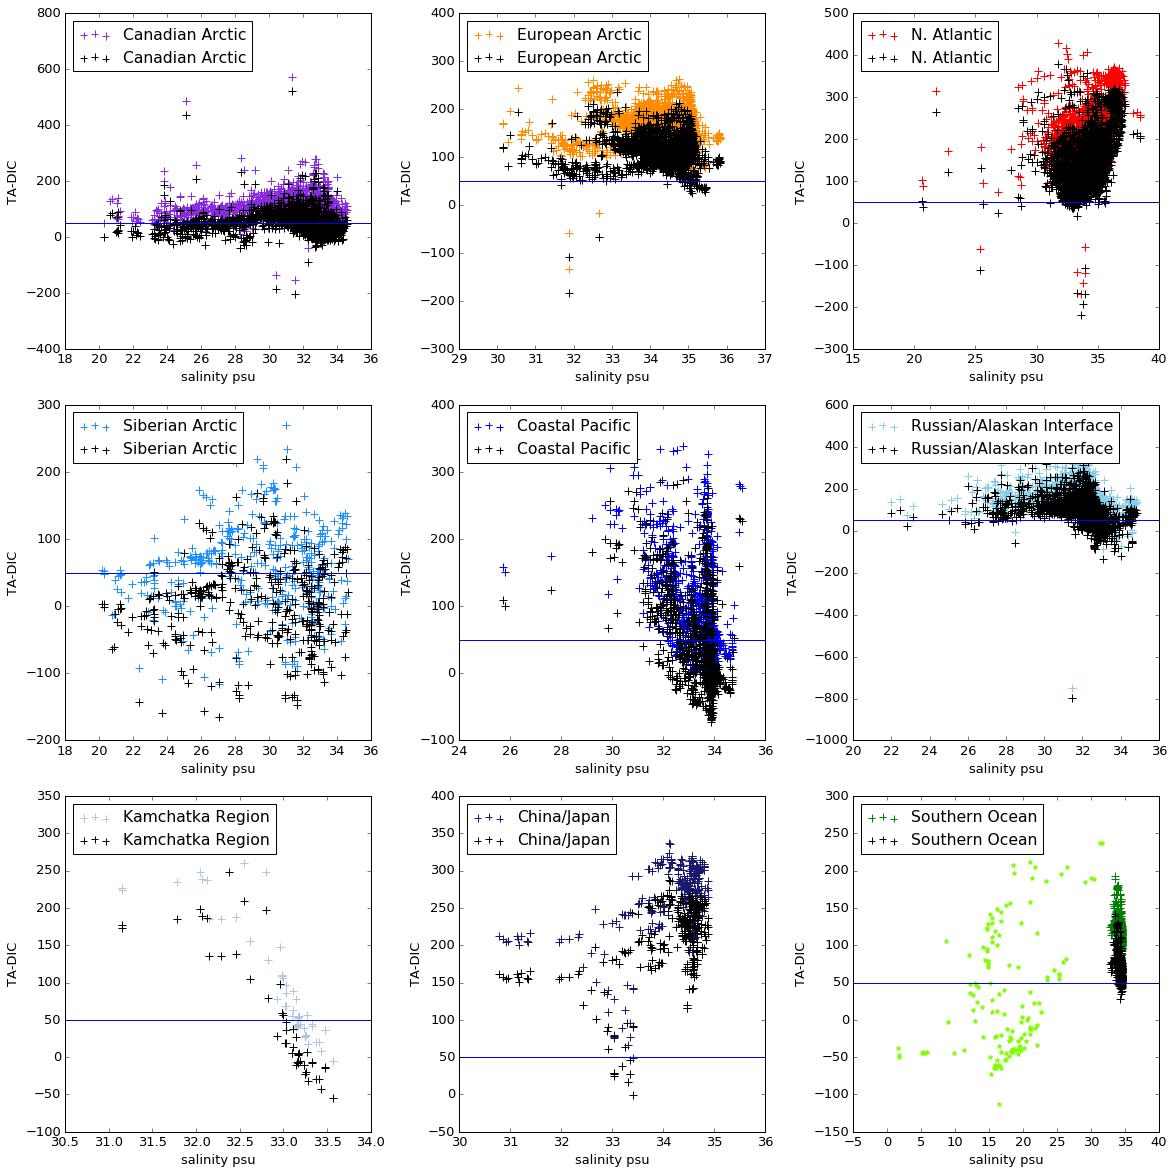

In [69]:


    
fact = 2.75
fig = plt.figure(figsize=(6*fact,6*fact))
ms = 9


lw = 2.5
for i in range(0,(len(list_places)-1)):
    
    ax1 = fig.add_subplot(3,3,i+1)

    tGEODAT = (PLACES_withdat[list_places[i]]['geodat'])
    tCOL = (PLACES_withdat[list_places[i]]['colour'])
    subsALK_DIC = tALK_DIC[filt_DEPTH2 & filt_EST & (tGEO == tGEODAT) & filt_SAL & filt_TEMP & filt_DIC & filt_ALK]
    subsALK_DIC_p = tALK_DIC_p[filt_DEPTH2 & filt_EST & (tGEO == tGEODAT) & filt_SAL & filt_TEMP & filt_DIC & filt_ALK]
    subsSAL = tSAL[filt_DEPTH2 & filt_EST & (tGEO == tGEODAT) & filt_SAL & filt_TEMP & filt_DIC & filt_ALK]
    x = subsSAL
    y = subsALK_DIC
    y2 = subsALK_DIC_p
    plt.scatter(x,y,c=tCOL, s = 50,marker = '+', label = PLACES_withdat[list_places[i]]['name'])
    plt.scatter(x,y2,c='black', s = 50,marker = '+', label = PLACES_withdat[list_places[i]]['name'])

    if i == 8:
        plt.scatter(sal_u,ta_u-dic_u,marker = '*', color = 'chartreuse')

    plt.axhline(y=50)
    plt.legend(loc = 'upper left')
    ax1.set_ylabel('TA-DIC')
    ax1.set_xlabel('salinity psu')

plt.tight_layout()


## Omega A vs salinity

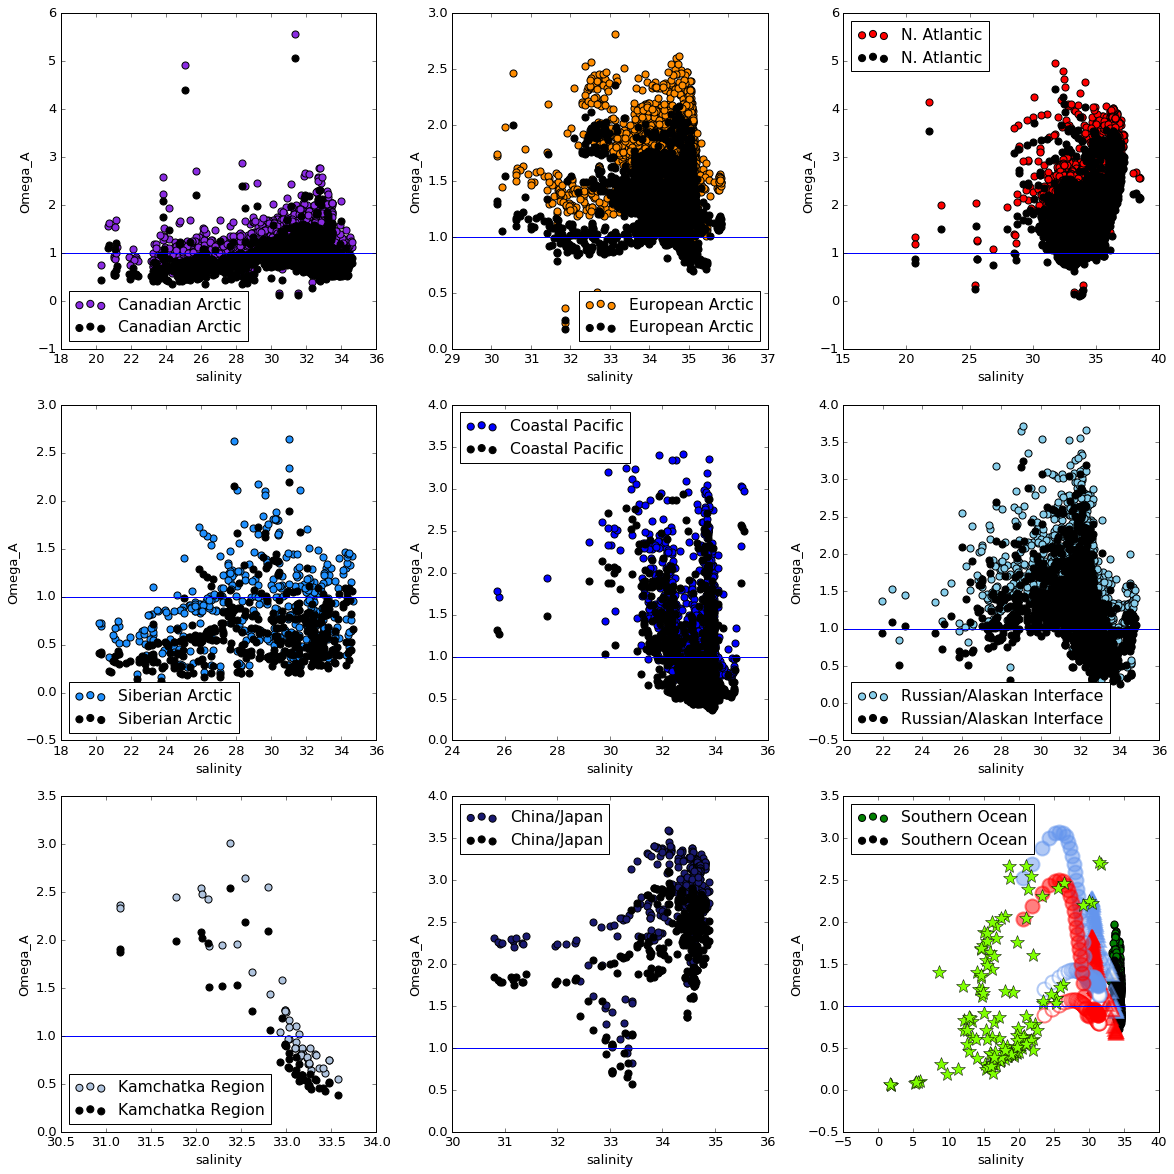

In [70]:
# plt.scatter(subsSAL,subsALK_DIC,c='blue', s = ts,marker = 'o', label = 'coastal GLODAP')
# plt.scatter(clos2SAL,subsALK_DIC[crit2],c='red', s = ts,marker = 'o', label = 'coastal GLODAP TA-DIC<50')
    
fact = 2.75
fig = plt.figure(figsize=(6*fact,6*fact))
ms = 9


lw = 2.5
tlen =(len(list_places)-1)
tlen = 9
for i in range(0,tlen):
  
    ax1 = fig.add_subplot(3,3,i+1)
    if i == 8:
        ax1.plot(PI4_sal_jdf_winter,PI4_OmegaA_A_jdf_winter, marker = '^', markersize =14,\
             markerfacecolor='white', alpha = 0.5, markeredgecolor='cornflowerblue',\
             markeredgewidth=2 ,  linestyle = 'None')
        ax1.plot(PI4_sal_jdf_summer,PI4_OmegaA_A_jdf_summer, marker = '^', markersize =14,\
             markerfacecolor='cornflowerblue', alpha = 0.5, markeredgecolor='cornflowerblue',\
             markeredgewidth=2 ,  linestyle = 'None')
        ax1.plot(BR3_sal_jdf_winter,BR3_OmegaA_A_jdf_winter, marker = '^', markersize =14,\
             markerfacecolor='white', alpha = 0.5, markeredgecolor='red',\
             markeredgewidth=2 ,  linestyle = 'None')
        ax1.plot(BR3_sal_jdf_summer,BR3_OmegaA_A_jdf_summer, marker = '^', markersize =14,\
             markerfacecolor='red', alpha = 0.5, markeredgecolor='red',\
             markeredgewidth=2 ,  linestyle = 'None')
        ax1.plot(PI4_sal_cs2_winter,PI4_OmegaA_A_cs2_winter, marker = 'o', markersize =14,\
             markerfacecolor='white', alpha = 0.5, markeredgecolor='cornflowerblue',\
             markeredgewidth=2 ,  linestyle = 'None')
        ax1.plot(PI4_sal_cs2_summer,PI4_OmegaA_A_cs2_summer, marker = 'o', markersize =14,\
             markerfacecolor='cornflowerblue', alpha = 0.5, markeredgecolor='cornflowerblue',\
             markeredgewidth=2 ,  linestyle = 'None')
        ax1.plot(BR3_sal_cs2_winter,BR3_OmegaA_A_cs2_winter, marker = 'o', markersize =14,\
             markerfacecolor='white', alpha = 0.5, markeredgecolor='red',\
             markeredgewidth=2 ,  linestyle = 'None')
        ax1.plot(BR3_sal_cs2_summer,BR3_OmegaA_A_cs2_summer, marker = 'o', markersize =14,\
             markerfacecolor='red', alpha = 0.5, markeredgecolor='red',\
             markeredgewidth=2 ,  linestyle = 'None')
        ax1.plot(sal_u,cai_OmegaA_A, marker = '*', color = 'chartreuse',\
                markersize = 14, linestyle = 'None')
    
    tGEODAT = (PLACES_withdat[list_places[i]]['geodat'])
    tCOL = (PLACES_withdat[list_places[i]]['colour'])
    subsALK_DIC = t_OmegaA_A[filt_DEPTH2 & filt_EST & (tGEO == tGEODAT) & filt_SAL & filt_TEMP & filt_DIC & filt_ALK]
    subsALK_DIC_p = t_OmegaA_A_p[filt_DEPTH2 & filt_EST & (tGEO == tGEODAT) & filt_SAL & filt_TEMP & filt_DIC & filt_ALK]

    subsSAL = tSAL[filt_DEPTH2 & filt_EST & (tGEO == tGEODAT) & filt_SAL & filt_TEMP & filt_DIC & filt_ALK]
    x = subsSAL
    y = subsALK_DIC
    y2 = subsALK_DIC_p

    plt.scatter(x,y,c=tCOL, s = 50,marker = 'o', label = PLACES_withdat[list_places[i]]['name'])
    plt.scatter(x,y2,c='black', s = 50,marker = 'o', label = PLACES_withdat[list_places[i]]['name'])

    
    plt.legend(loc = 'upper left')
    ax1.set_ylabel('TA-DIC')
    ax1.set_xlabel('salinity psu')

    ax1.axhline(y=1)
    ax1.legend(loc = 'best')
    ax1.set_ylabel('Omega_A')
    ax1.set_xlabel('salinity')

plt.tight_layout()

## Omega_DIC

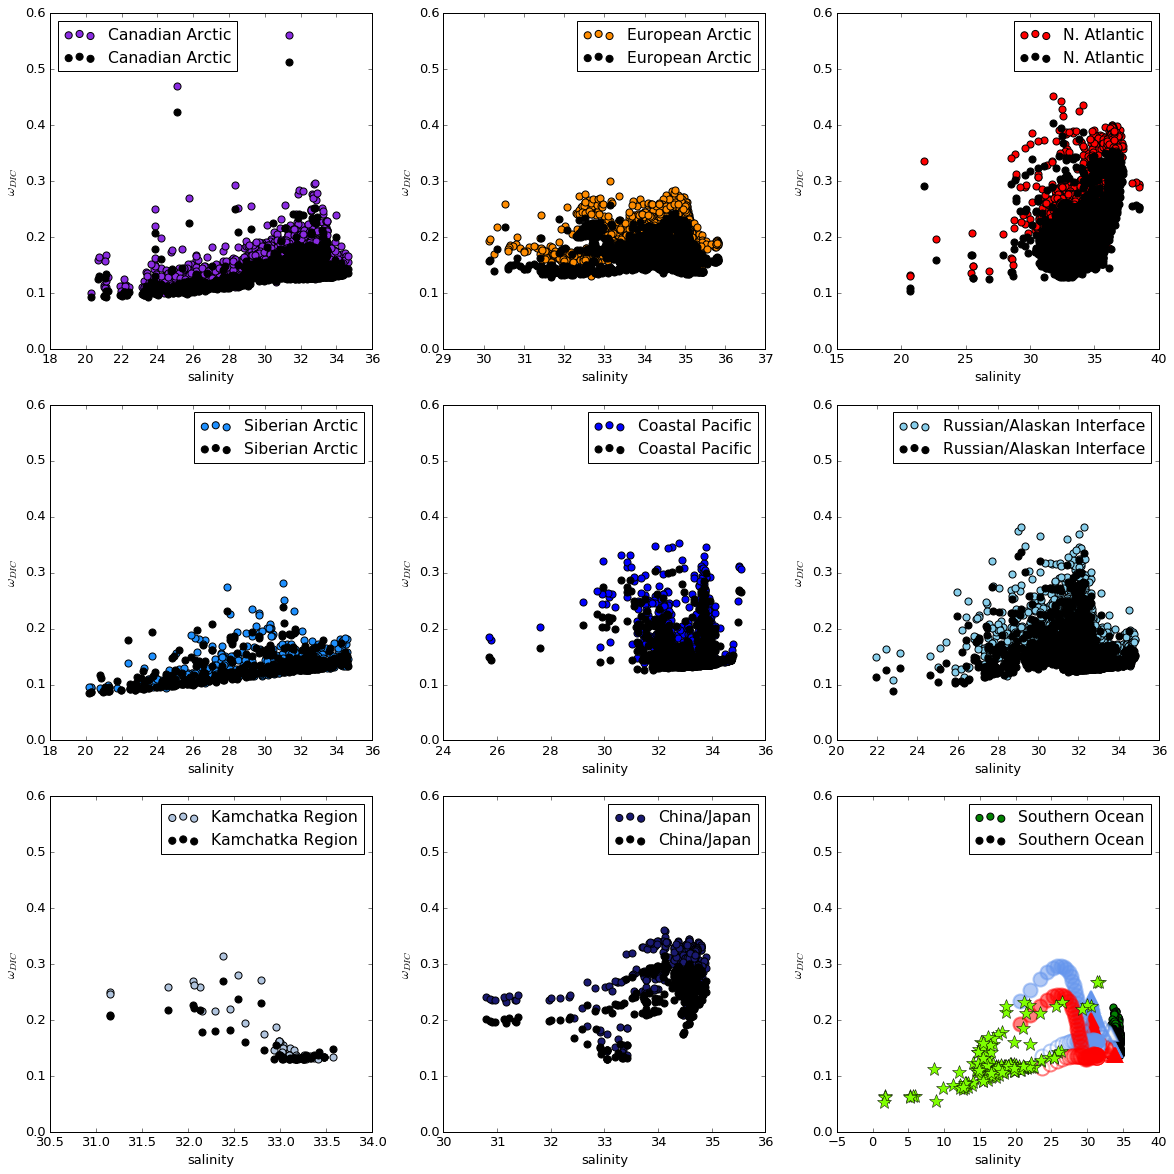

In [71]:
# plt.scatter(subsSAL,subsALK_DIC,c='blue', s = ts,marker = 'o', label = 'coastal GLODAP')
# plt.scatter(clos2SAL,subsALK_DIC[crit2],c='red', s = ts,marker = 'o', label = 'coastal GLODAP TA-DIC<50')
    
fact = 2.75
fig = plt.figure(figsize=(6*fact,6*fact))
ms = 9


lw = 2.5
tlen =(len(list_places)-1)
tlen = 9
for i in range(0,tlen):
  
    ax1 = fig.add_subplot(3,3,i+1)
    if i == 8:
        ax1.plot(PI4_sal_jdf_winter,-PI4_omega_DIC_jdf_winter, marker = '^', markersize =14,\
             markerfacecolor='white', alpha = 0.5, markeredgecolor='cornflowerblue',\
             markeredgewidth=2 ,  linestyle = 'None')
        ax1.plot(PI4_sal_jdf_summer,-PI4_omega_DIC_jdf_summer, marker = '^', markersize =14,\
             markerfacecolor='cornflowerblue', alpha = 0.5, markeredgecolor='cornflowerblue',\
             markeredgewidth=2 ,  linestyle = 'None')
        ax1.plot(BR3_sal_jdf_winter,-BR3_omega_DIC_jdf_winter, marker = '^', markersize =14,\
             markerfacecolor='white', alpha = 0.5, markeredgecolor='red',\
             markeredgewidth=2 ,  linestyle = 'None')
        ax1.plot(BR3_sal_jdf_summer,-BR3_omega_DIC_jdf_summer, marker = '^', markersize =14,\
             markerfacecolor='red', alpha = 0.5, markeredgecolor='red',\
             markeredgewidth=2 ,  linestyle = 'None')
        ax1.plot(PI4_sal_cs2_winter,-PI4_omega_DIC_cs2_winter, marker = 'o', markersize =14,\
             markerfacecolor='white', alpha = 0.5, markeredgecolor='cornflowerblue',\
             markeredgewidth=2 ,  linestyle = 'None')
        ax1.plot(PI4_sal_cs2_summer,-PI4_omega_DIC_cs2_summer, marker = 'o', markersize =14,\
             markerfacecolor='cornflowerblue', alpha = 0.5, markeredgecolor='cornflowerblue',\
             markeredgewidth=2 ,  linestyle = 'None')
        ax1.plot(BR3_sal_cs2_winter,-BR3_omega_DIC_cs2_winter, marker = 'o', markersize =14,\
             markerfacecolor='white', alpha = 0.5, markeredgecolor='red',\
             markeredgewidth=2 ,  linestyle = 'None')
        ax1.plot(BR3_sal_cs2_summer,-BR3_omega_DIC_cs2_summer, marker = 'o', markersize =14,\
             markerfacecolor='red', alpha = 0.5, markeredgecolor='red',\
             markeredgewidth=2 ,  linestyle = 'None')
        ax1.plot(sal_u,-cai_omega_DIC, marker = '*', markersize = 14, color = 'chartreuse', linestyle = 'none')
    
    tGEODAT = (PLACES_withdat[list_places[i]]['geodat'])
    tCOL = (PLACES_withdat[list_places[i]]['colour'])
    subsALK_DIC = -t_omega_DIC[filt_DEPTH2& filt_EST & (tGEO == tGEODAT) & filt_SAL & filt_TEMP & filt_DIC & filt_ALK]
    subsALK_DIC_p = -t_omega_DIC_p[filt_DEPTH2& filt_EST & (tGEO == tGEODAT) & filt_SAL & filt_TEMP & filt_DIC & filt_ALK]
    
    subsSAL = tSAL[filt_DEPTH2& filt_EST & (tGEO == tGEODAT) & filt_SAL & filt_TEMP & filt_DIC & filt_ALK]
    x = subsSAL
    y = subsALK_DIC
    y2 = subsALK_DIC_p
    plt.scatter(x,y,c=tCOL, s = 50,marker = 'o', label = PLACES_withdat[list_places[i]]['name'])
    plt.scatter(x,y2,c='black', s = 50,marker = 'o', label = PLACES_withdat[list_places[i]]['name'])

    plt.legend(loc = 'upper left')
    ax1.set_ylabel('TA-DIC')
    ax1.set_xlabel('salinity psu')
    ax1.set_ylim([0,0.6])

    
    ax1.legend(loc = 'best')
    ax1.set_ylabel('$\omega_{DIC}$')
    ax1.set_xlabel('salinity')

plt.tight_layout()